<a href="https://colab.research.google.com/github/shiny880410/helloworld/blob/master/final/PCA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gspread
!pip install oauth2client
!pip install Pillow
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 5.0MB/s 


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1_7FyladR7eGnmUjsCvNF1XnpVZpuNGXm' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  #fname = os.path.join(local_download_path, f['title'])
  fname = os.path.join('/content', f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  #f_.GetContentFile(fname)
!ls "/root/data"

title: PCA3.ipynb, id: 1TQTW1NGCuVNsngSn0_mYcePCENYooduB
downloading to /content/PCA3.ipynb
title: trainingdata, id: 1_L_CG5WhF5oZUvpmJTWEbEmHHGJ1-boQ9oxyfILFJyU
downloading to /content/trainingdata
title: datascience final, id: 1ACNaFULWc7k1iO9GCjpcKbu3RB0O81z2xHdDfjymZeM
downloading to /content/datascience final
title: data, id: 1abC0kNTX9YRXDCMU-v9c9aYlXSGakNKbVcIR9t-YgH0
downloading to /content/data
title: 道路資料, id: 1n13LzaLqwxIJZ32MkoXlc8mKzfFs6bc08NIheZoCcJc
downloading to /content/道路資料
title: 車流, id: 1pL-toXHxIuYvDOBiYbBKijGGdAeVuT4FhFZVq-tx3Q0
downloading to /content/車流
title: 車速, id: 1FJPf9S2vpimDZvefrpnfq31cq3JpmySHse74WQoEgu4
downloading to /content/車速
title: 107年-臺北市A1及A2類交通事故明細, id: 1A3V6ncj7VLNDiDkchaYPIYmqrA0trkEj8L-tHoaAyZs
downloading to /content/107年-臺北市A1及A2類交通事故明細
title: train data, id: 1ONnWx9WmHGtkMRsaPO5PHEcpzYvkvTkC
downloading to /content/train data
title: PCA2.ipynb, id: 1X2CsY7FaXplAqL4LGAljtnqDhcTnqjET
downloading to /content/PCA2.ipynb
title: practice.ipynb

In [0]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from oauth2client.client import GoogleCredentials
from google.colab import auth
from google.colab import files
auth.authenticate_user()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from IPython.display import Image
from wordcloud import WordCloud, ImageColorGenerator
import re
import jieba
import time
import pandas as pd
import math
from collections import Counter
import codecs
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from gspread_dataframe import get_as_dataframe, set_with_dataframe

gc = gspread.authorize(GoogleCredentials.get_application_default())
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1A3V6ncj7VLNDiDkchaYPIYmqrA0trkEj8L-tHoaAyZs/edit#gid=154609684')
wks4 = sh.worksheet("data3")
wks3 = sh.worksheet("對照表")

df = get_as_dataframe(wks4,parse_dates=True,usecols=[1,2],header=None)
df.head()


,1,2
0,類別,內容
1,死亡,死亡死亡死亡死亡大同區台北橋汽車道往三重大型重型機車2(250-550C.C.)自用小貨車計...
2,死亡,死亡死亡大同區民族西路284號與民族西路口普通重型機車行人男性男性知天命古稀晴天0多岔路交叉口附近
3,死亡,死亡死亡死亡大同區忠孝橋機車道號往三重機車道普通重型機車0乘客男性動物、堆置物女性至學至學至...
4,死亡,死亡死亡大同區台北橋機車引道三重往台北普通重型機車0男性動物、堆置物知天命至學晴天40Km/...


In [0]:
label = get_as_dataframe(wks3,parse_dates=True,usecols=[5,6],header=None)
label[:69]

,5,6
0,受傷,Hurt
1,死亡,Die
2,公營公車,Public Bus
3,民營公車,Private Bus
4,公營客運,Public Passenger Bus
5,民營客運,Private Passenger Bus
6,遊覽車,Tour Bus
7,自用大客車,Personal Bus
8,營業用大貨車,Company Large Truck
9,自用大貨車,Personal Large Truck


In [0]:
import random
r=(random.sample(range(75,22501), 300))
df1=df.iloc[r]
df1.head()
#df.iloc[[2,7]]

,1,2
19961,受傷,受傷受傷南港區市民大道7段與玉成街口普通重型機車普通重型機車男性男性至學至學陰天50Km/h...
2048,受傷,受傷受傷萬華區環河南路2段37號與環河南路2段口普通重型機車普通重型機車男性女性至學至學晴天...
936,受傷,受傷大同區承德路3段與民族西路口普通重型機車女性不惑晴天50Km/hr四岔路交叉口附近
4435,受傷,受傷受傷中山區龍江路與建國北路1段23巷口自用小客車行人男性男性而立知天命陰天40Km/hr...
12197,受傷,受傷受傷受傷士林區格致路與愛富二街口自用小客車普通重型機車乘客男性男性女性而立而立而立晴天4...


In [0]:
matrix = []
#df1 = df[76:350]
label1 = label[:69]
#print(len(df1))
for i in range(len(label1)):
  matrix.append([])
  for j in range(len(label1)):
    ct = 0 
    for k in df1[2]:
      if(label1[5][i] in k)  & (label1[5][j] in k ):
        ct+=1
    matrix[i].append(ct)    
matrix = pd.DataFrame(matrix)

matrix.columns = label1[5]
matrix.index = label1[5]
pd.set_option('display.max_columns', 69)
pd.set_option('display.max_rows', 69)
matrix.head(69)

5,受傷,死亡,公營公車,民營公車,公營客運,民營客運,遊覽車,自用大客車,營業用大貨車,自用大貨車,營業用半聯結車,營業用曳引車,計程車,租賃車,自用小客車,營業用小貨車,自用小貨車,大型重型機車1(550C.C.以上),大型重型機車2(250-550C.C.),普通重型機車,腳踏自行車,行人,乘客,男性,女性,暴雨,雨天,陰天,晴天,三岔路,四岔路,多岔路,隧道,地下道,橋樑,涵洞,高架道路,彎曲路及附近,坡路,巷弄,直路,圓環,廣場,交叉路口內,交叉口附近,機車待轉區,機車停等區,交通島,迴轉道,快車道,慢車道,一般車道,公車專用道,機車專用道,機車優先道,路肩、路緣,行人穿越道,穿越道附近,人行道,至學,而立,不惑,知天命,耳順,耄耋,古稀,50Km/hr,40Km/hr,30Km/hr
5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
受傷,300,0,0,1,0,2,0,0,1,1,0,1,50,15,116,2,15,1,3,245,16,32,32,275,157,1,49,52,198,57,108,8,1,1,1,0,2,6,1,5,99,2,0,119,54,0,0,0,1,6,10,96,0,6,2,0,2,0,1,184,93,90,89,61,3,20,199,66,30
死亡,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
公營公車,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
民營公車,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
公營客運,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
民營客運,2,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,2,1,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,0,1,0,1
遊覽車,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
自用大客車,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
營業用大貨車,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0


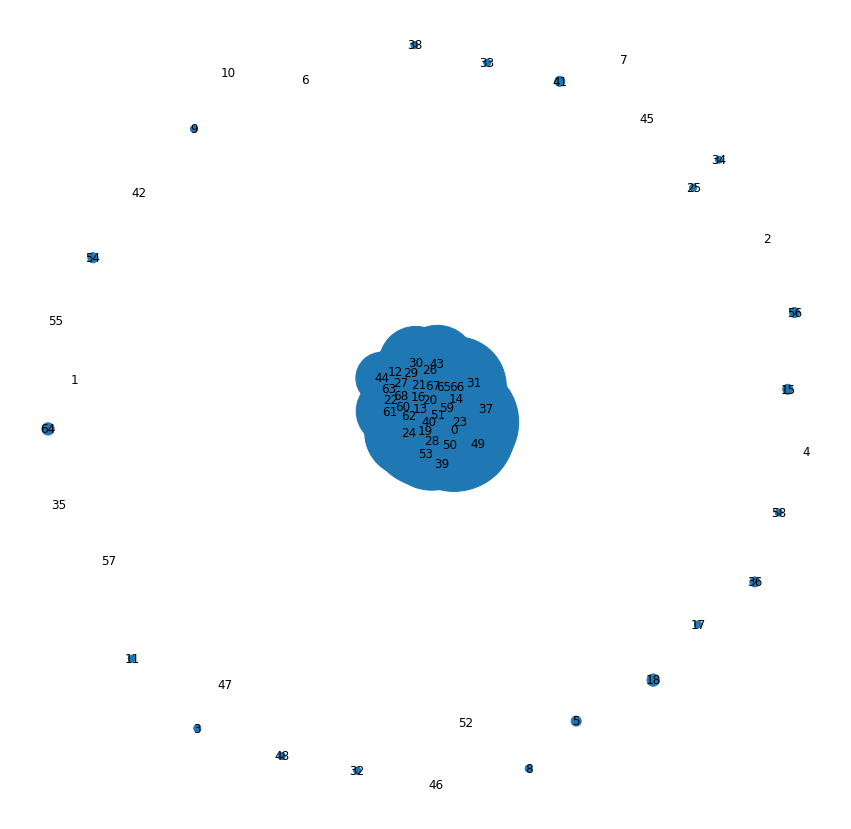

In [0]:
import networkx as nx
import matplotlib.font_manager as fm
import matplotlib
plt.subplots(figsize=(15,15))
G = nx.DiGraph()
G.add_nodes_from(range(len(label1[5])))
widths = [] 
sizes = []
for i in range(len(label1[5])):
  for j in range(len(label1[5])):
    w = matrix[label1[5][i]][label1[5][j]]
    if i==j:
      sizes.append(w*50)
      continue
    if w<=3:
      continue
    widths.append(w/10)
    #if w==0:
    #  w=0.1
    #print(type(w))
    
    G.add_edges_from([(i,j)], weight=1/w)
nx.draw(G,with_labels=True,width=widths,node_size = sizes)

In [0]:
label2=label.drop([6,15,7,36,38,45,56,57,39,48,11,4,41,17,58,64,47,5,35,54,34,52,2,33,42,32,37,3,55,18,25,49,46,58,50,1,9,8,10,65,53])
label2=label2[:29]
label2.head(29)


,5,6
0,受傷,Hurt
12,計程車,Taxi
13,租賃車,Rental Car
14,自用小客車,Personal Passenger Car
16,自用小貨車,Personal Small Truck
19,普通重型機車,Motocycle
20,腳踏自行車,Bike
21,行人,Pedestrian
22,乘客,Passenger
23,男性,Male


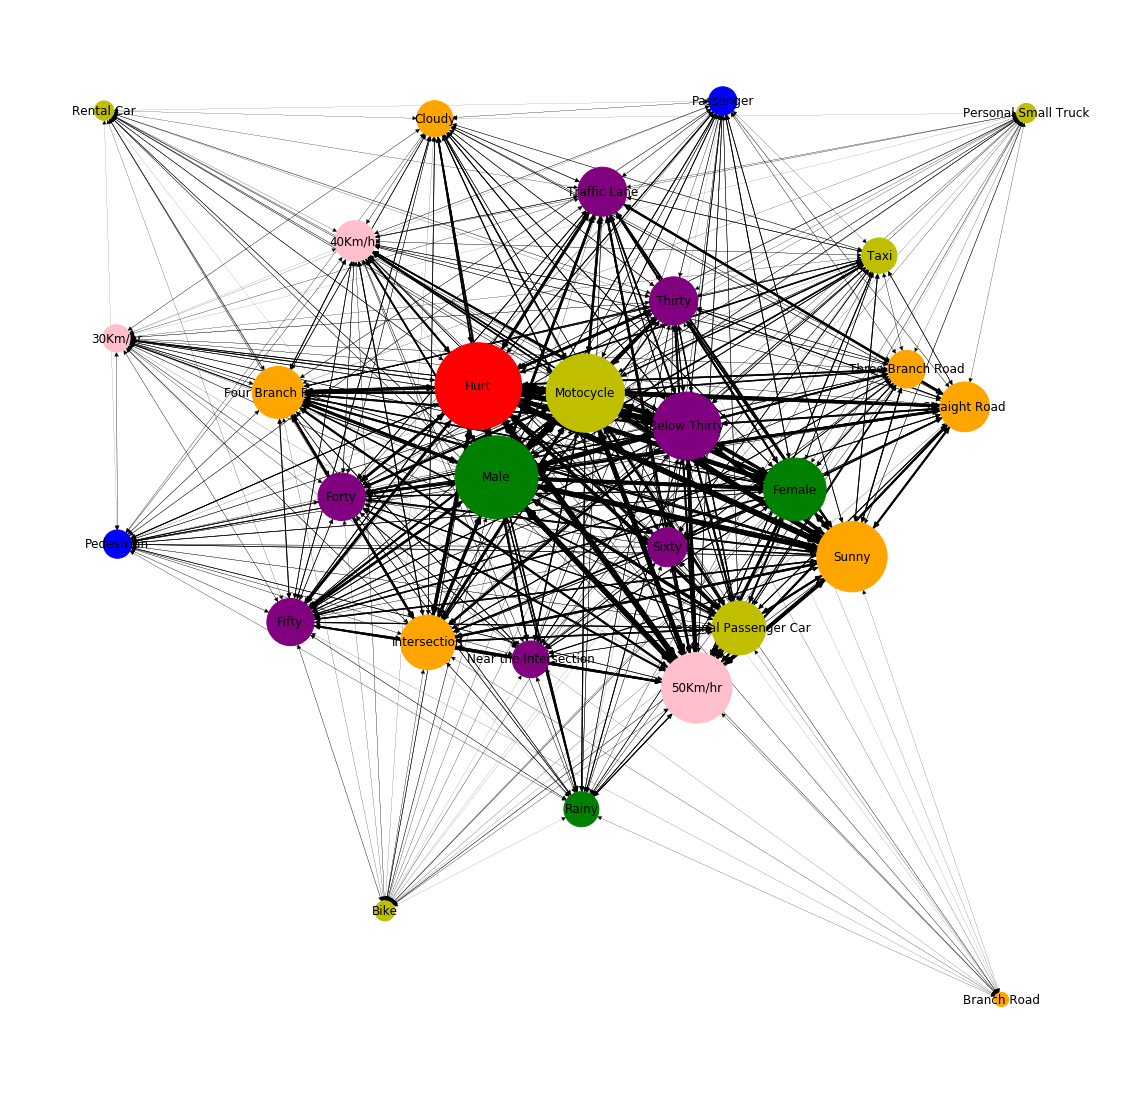

In [0]:
import networkx as nx
import matplotlib.font_manager as fm
import matplotlib
import math
plt.subplots(figsize=(20,20))
G = nx.DiGraph()
#G.add_nodes_from(label2.index.tolist())
G.add_nodes_from(label2[6].tolist())
widths = [] 
sizes = []
for i in label2.index.tolist():
  for j in label2.index.tolist():
    w = matrix[label2[5][i]][label2[5][j]]
    if i==j:
      sizes.append(w*25)
      continue
    if w<=1:
      continue
    widths.append(w/35)    
    #G.add_edges_from([(i,j)], weight=-25*math.log(1/w))
    G.add_edges_from([(label2[6][i],label2[6][j])], weight=-30*math.log(1/w))
pos = nx.spring_layout(G, k=0.5, iterations=20)
colors=['r','y','y','y','y','y','y','b','b','g','g','g','orange','orange','orange','orange','orange','orange','orange','purple','purple','purple','purple','purple','purple','purple','pink','pink','pink']

nx.draw(G,pos,with_labels=True,width=widths,node_size = sizes,node_color=colors)